# Machine Learning and Pattern Recognition CO2 Project Work
## Sepsis Mars Endotype and Survival Prediction through Gene Expression
##### Participants: Daniela Charraga Garcia, Flavia D'Eramo, Jolafin Hostettler

### Project Overview and Research Question
Sepsis is a life-threatening condition where the body’s response to infection becomes dysregulated. A key challenge is that two patients with sepsis can look similar clinically but have very different underlying immune responses and outcomes. 

In their paper, Scicluna et. al used whole-blood transcriptomic profiles from ICU patients with sepsis to address the problem with the heterogeneity in the sepsis diagnosis. They applied unsupervised learning to the gene expression data to identify four molecular endotypes (Mars1–Mars4). The aim was to discover data-driven subgroups that reflect different host-response patterns and that could help with risk stratification and therefore more tailored treatment decisions. In the paper, these endotypes were linked to clinical traits and differences in mortality risk. 

In this project, we “work backwards” from that idea using a supervised learning approach and ask; "Can we learn to predict the published MARS endotypes (Mars1–Mars4) from baseline whole-blood transcriptomic data, and do these predicted endotypes still stratify 28-day mortality risk?"

To answer this, we compare a baseline linear model to more flexible models, tune hyperparameters using cross-validation, and evaluate performance on held-out data. We then relate endotype predictions to 28-day mortality to check whether the stratification signal remains visible in our modelling pipeline.

<br>
<br>


### What the data represents and how the matrices were prepared

#### Dataset 
We use the public GEO dataset GSE65682, generated on the Affymetrix U219 microarray platform. The dataset contains genome-wide gene expression profiles from adult ICU sepsis patients and healthy controls, alongside patient-level clinical metadata and outcomes including 28-day mortality

#### Background on microarray measurements 
Microarrays quantify RNA abundance for thousands of transcripts at once using probe sets designed for specific genes. After preprocessing, each sample becomes a vector of gene expression values (typically on a log scale), which can be used as input features for machine learning.

#### How we accessed and built the working matrices 
To keep the workflow reproducible, we rebuilt the expression matrix and metadata table from GEO:

1. **Access expression data and metadata**
   - Expression data and sample annotations were downloaded from GEO (GSE65682).
   - Sample metadata were retrieved from the GEO series matrix (phenotype table).

2. **Normalization**
   - The expression values used for modeling are based on a normalized microarray expression set (log-scale). 
   - The dataset is also available in processed form from GEO, which is the one that was used in this project

3. **Map probes to gene symbols**
   - Microarrays measure probe sets rather than genes directly, so obtaining the expression matrix involves mapping each probe ID to a gene symbol 
   - Probes that could not be mapped to a gene symbol were removed.

4. **Collapse probes to a single gene value**
   - Multiple probes can map to the same gene. For simplicity and to obtain a clean gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
   - This produces one value per gene per sample.

5. **Construct `X` and align with phenotype data**
   - The final expression matrix **`X`** has shape **samples × genes** (479 sepsis samples with Mars endotypes; ~19k gene symbols after collapsing).
   - A matching phenotype/metadata table contains the **endotype labels** (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
   - Sample IDs were intersected and reordered so that the rows of `X` match the rows of the metadata exactly.

For this endotype-prediction task, we use **transcriptomic features only** (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.



### Project Workflow

1. **Exploration and sanity checks**
   - Inspect class imbalance across Mars1–Mars4, check missingness, and use PCA to visualise major sources of variation (including checking whether discovery vs validation cohorts dominate the signal).

2. **Endotype prediction (supervised learning)**
   - Train models to classify **Mars1–Mars4** from baseline gene expression.
   - Models used:
     - Logistic regression (baseline)
     - Random forest
     - Svm 
     - Gradient Boosting
   - Feature selection uses **variance filtering inside cross-validation** 
   - Performance is reported with macro-F1, balanced accuracy, and confusion matrices.

3. **Mortality analysis**
   - Use the available 28-day outcome labels to examine whether predicted endotypes still stratify mortality risk in the expected direction (e.g., higher risk for Mars1 in the original study).

4. **Interpretation**
   - Summarise which genes are retained by variance filtering and discuss how model performance and error patterns relate to the biological idea of the different host-response endotypes.



#### Imports

In [1]:
# General data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# selfmade plotting script with plot functions
from plotting import (
    plot_counts,
    plot_counts_ax,
    plot_missingness_bar_ax,
    plot_missingness_hist_ax,
    plot_expression_distributions,
    plot_pca_ax,
    plot_cm_and_optional_roc,
    evaluate_multiclass
) 

# Preprocessing libraries
from sklearn.impute import SimpleImputer # + in modeling
from sklearn.preprocessing import StandardScaler, label_binarize # + in modeling
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, log_loss
from sklearn.base import BaseEstimator, TransformerMixin, clone

# models used
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Parameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [2]:
metadata = pd.read_csv("metadata.csv", index_col=0)
xgene_data = pd.read_csv("gene_expression.csv", index_col=0)

assert set(xgene_data.columns) == set(metadata.index) # sanity check if everything is still properly strcutured (needed in preprocessing etc.)

In [3]:
xgene_data.head()

,GSM1602802,GSM1602803,GSM1602805,GSM1602807,GSM1602809,GSM1602810,GSM1602811,GSM1602812,GSM1602813,GSM1602815,...,GSM1692484,GSM1692488,GSM1692489,GSM1692491,GSM1692492,GSM1692493,GSM1692494,GSM1692498,GSM1692499,GSM1692501
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
A4GALT,2.370856,2.333772,2.203786,2.718429,2.242565,2.571770,2.247910,2.642772,2.914867,2.294185,...,2.756667,2.998413,2.945314,2.585448,2.556196,2.682765,2.507921,3.293136,2.436474,2.778657
AAA1,3.104086,3.565000,3.847223,2.873127,3.105889,3.071141,3.642397,3.870772,3.498634,3.182019,...,3.364867,4.008958,3.851971,3.560053,3.564106,3.166076,3.414724,3.671216,3.613478,3.513017
AACS,2.741084,2.540278,2.413356,2.996410,2.624628,2.322627,2.724906,2.501046,2.885711,2.836082,...,2.715641,2.552206,2.444574,2.751261,2.581893,2.620099,2.597717,2.796224,2.504522,2.544067
AAGAB,5.371443,5.133350,4.917349,4.755012,5.731680,5.888738,4.682901,4.843935,4.882377,5.265388,...,4.352681,5.256867,4.873837,5.679272,5.211013,4.991676,4.653208,4.426896,4.825203,5.000168
AAK1,5.379089,5.703805,4.639995,5.593209,5.489802,5.289881,5.389003,5.309633,3.777562,4.096500,...,4.675973,5.164079,4.667160,4.743483,5.544114,5.628138,4.622742,4.886943,5.847914,5.380113


In [4]:
metadata.head()

,sample_title,sample_status,sample_submission_date,sample_last_update_date,sample_type,sample_channel_count,sample_source_name_ch1,sample_organism_ch1,sample_treatment_protocol_ch1,sample_growth_protocol_ch1,...,endotype_cohort,gender,icu_acquired_infection,icu_acquired_infection_paired,mortality_event_28days,pneumonia_diagnoses,thrombocytopenia,time_to_event_28days,is_mars,is_healthy
GSM1602802,intensive-care unit patient [03_04_2013_B06_1793],Public on Jul 06 2015,Feb 05 2015,Jul 12 2018,RNA,1,whole blood,Homo sapiens,PAXgene blood RNA tubes were left at room temp...,Whole blood was collected in PAXgene blood RNA...,...,discovery,female,No_ICUA,NaN,0.0,cap,NaN,28.0,True,False
GSM1602803,intensive-care unit patient [03_04_2013_B07_3252],Public on Jul 06 2015,Feb 05 2015,Jul 12 2018,RNA,1,whole blood,Homo sapiens,PAXgene blood RNA tubes were left at room temp...,Whole blood was collected in PAXgene blood RNA...,...,discovery,male,NaN,NaN,0.0,cap,NaN,28.0,True,False
GSM1602805,intensive-care unit patient [03_04_2013_C08_2736],Public on Jul 06 2015,Feb 05 2015,Jul 12 2018,RNA,1,whole blood,Homo sapiens,PAXgene blood RNA tubes were left at room temp...,Whole blood was collected in PAXgene blood RNA...,...,discovery,female,No_ICUA,NaN,0.0,cap,NaN,28.0,True,False
GSM1602807,healthy subject [03_04_2013_E09_hv59],Public on Jul 06 2015,Feb 05 2015,Jul 12 2018,RNA,1,whole blood,Homo sapiens,PAXgene blood RNA tubes were left at room temp...,Whole blood was collected in PAXgene blood RNA...,...,NaN,male,healthy,healthy,NaN,NaN,NaN,NaN,False,True
GSM1602809,healthy subject [03_04_2013_F10_hv49],Public on Jul 06 2015,Feb 05 2015,Jul 12 2018,RNA,1,whole blood,Homo sapiens,PAXgene blood RNA tubes were left at room temp...,Whole blood was collected in PAXgene blood RNA...,...,NaN,male,healthy,healthy,NaN,NaN,NaN,NaN,False,True


#### Freeze canonical data objects

In [5]:
geneX = xgene_data.copy()       # genes x samples
meta_aligned = metadata.copy()  # samples x metadata

# Standardize GSM identifiers -> should avoid mismatches
geneX.columns = geneX.columns.astype(str).str.strip()
meta_aligned.index = meta_aligned.index.astype(str).str.strip()

# Inner-join on samples (GSM IDs) so expression and metadata refer to same samples
common = geneX.columns.intersection(meta_aligned.index)

geneX = geneX.loc[:, common].copy()        # genes x common_samples
meta_aligned = meta_aligned.loc[common].copy()  # common_samples x metadata

# Create the canonical analysis matrix (samples x genes)
X_all = geneX.T.copy()

dup = geneX.index.duplicated().sum()
print("Duplicated genes in geneX index:", dup)

if dup > 0:
    geneX = geneX.groupby(geneX.index).mean()

# 5) Sanity checks (fail fast if something is wrong)
print("geneX (genes x samples):", geneX.shape)
print("meta_aligned (samples x meta):", meta_aligned.shape)
print("X_all (samples x genes):", X_all.shape)

assert geneX.shape[1] == meta_aligned.shape[0], "Mismatch: geneX samples != meta_aligned samples"
assert all(geneX.columns == meta_aligned.index), "Mismatch: geneX columns and meta_aligned index differ"
assert all(X_all.index == meta_aligned.index), "Mismatch: X_all index and meta_aligned index differ"

# Optional orientation sanity check (typical for gene expression: more genes than samples)
assert X_all.shape[0] < X_all.shape[1], "X_all looks like genes x samples; expected samples x genes"

Duplicated genes in geneX index: 0
geneX (genes x samples): (11222, 521)
meta_aligned (samples x meta): (521, 43)
X_all (samples x genes): (521, 11222)


This step is for alignment of the data and creation of canonical data objects for reproducible downstream analysis.
Gene expression and sample metadata were aligned using GEO sample accession identifiers (GSM IDs). Only samples present in both the expression matrix and the metadata table were used (inner join). 
The gene expression matrix was stored in a gene-by-sample format, and then transposed to a sample-by-gene format (X_all) for all downstream exploratory analyses and supervised modeling, ensuring that each row corresponds to one patient/sample and each column to one gene. 
This format was used to avoid orientation errors and to ensure reproducible preprocessing across objectives.

### **Data Analysis and Preprocessing**
• Analyse your data. Visualise and explain the data features you deem to be relevant for the project.
• Explain what kind of preprocessing, feature encoding you are applying

#### Sample-level EDA and Filtering
In this section we perform exploratory data analysis (EDA) on the gene expression matrix and metadata to check and understand the distribution of samples, identify any missing values, and visualize key features.

Starting point:
- gene expression matrix with rows = samples (GSM), columns = genes (GeneSymbol)
- metadata : metadata with index = GSM, aligned to gene expression index


In [6]:
samplecheck = meta_aligned["is_healthy"].value_counts() # True = healthy samples, False = sepsis samples
print(samplecheck) # Sepsis = 479 samples, Healthy = 42 samples
print("Total Samples:", samplecheck.sum())

is_healthy
False    479
True      42
Name: count, dtype: int64
Total Samples: 521


The aligned dataset has 521 samples, from which 479 are septic patients and 42 are healthy controls (as expected)
This class imbalance has to be considered during model development (resampling or class-weighting)

##### Overall Sanity Check Expression Data

In [7]:
# X_all is samples x genes
print(geneX.shape)

# Quick summary of values
vals = geneX.values.ravel()
vals = vals[~np.isnan(vals)]
print(pd.Series(vals).describe())

(11222, 521)
count    5.846662e+06
mean     4.303250e+00
std      1.909361e+00
min      1.179992e+00
25%      2.833770e+00
50%      3.699503e+00
75%      5.347557e+00
max      1.353620e+01
dtype: float64


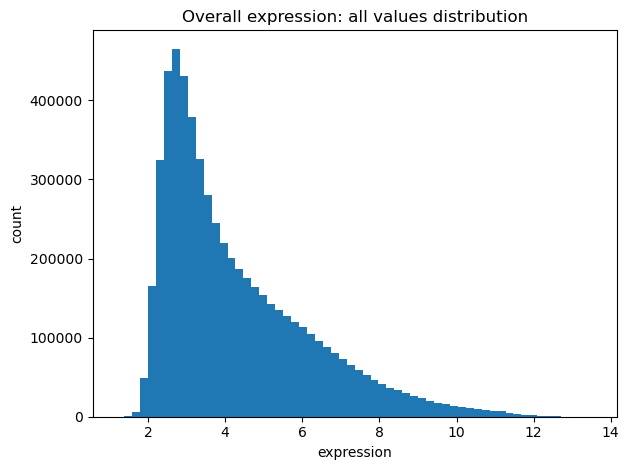

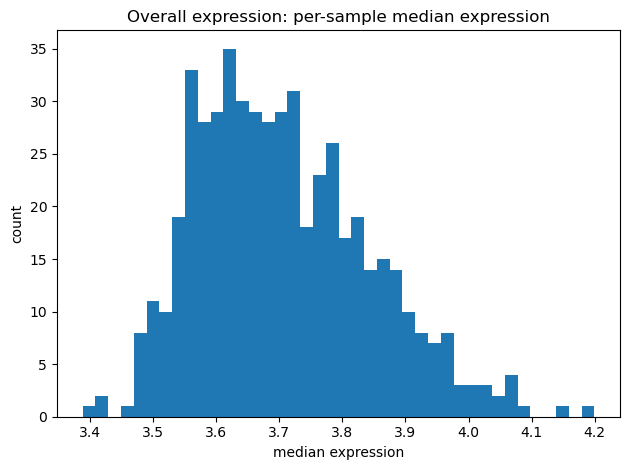

Expression missingness per sample summary:
count    521.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

Expression missingness per gene summary:
count    11222.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64


In [ ]:
# Expression distribution (all values + per-sample medians)
_ = plot_expression_distributions(X_all, title_prefix="Overall expression")

# missingness
expr_na_sample = X_all.isna().mean(axis=1)
expr_na_gene = X_all.isna().mean(axis=0)

# print("Expression missingness per sample summary:")
# print(expr_na_sample.describe())

# print("\nExpression missingness per gene summary:")
# print(expr_na_gene.describe())
# --> everything was 0% missingness, so no need to impute or filter

Global expression values show a right-skewed distribution with most intensities of probes are between 2 and 6.
Per-sample median expression levels are clustered between 3.4 and 4.1. This suggests a good overall normalization and no obvious intensity outliers. 
Expression missingness is effectively zero both across samples and across genes, so no imputation is required at this stage 

HERE explain technicality why we do etc. etc.

##### Label Distributions

Objective 1
 1.0    479
0.0     42
Name: count, dtype: int64
Objective 2
 endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
NaN       42
Name: count, dtype: int64
Objective 3
 mortality_event_28days
0.0    365
1.0    114
NaN     42
Name: count, dtype: int64


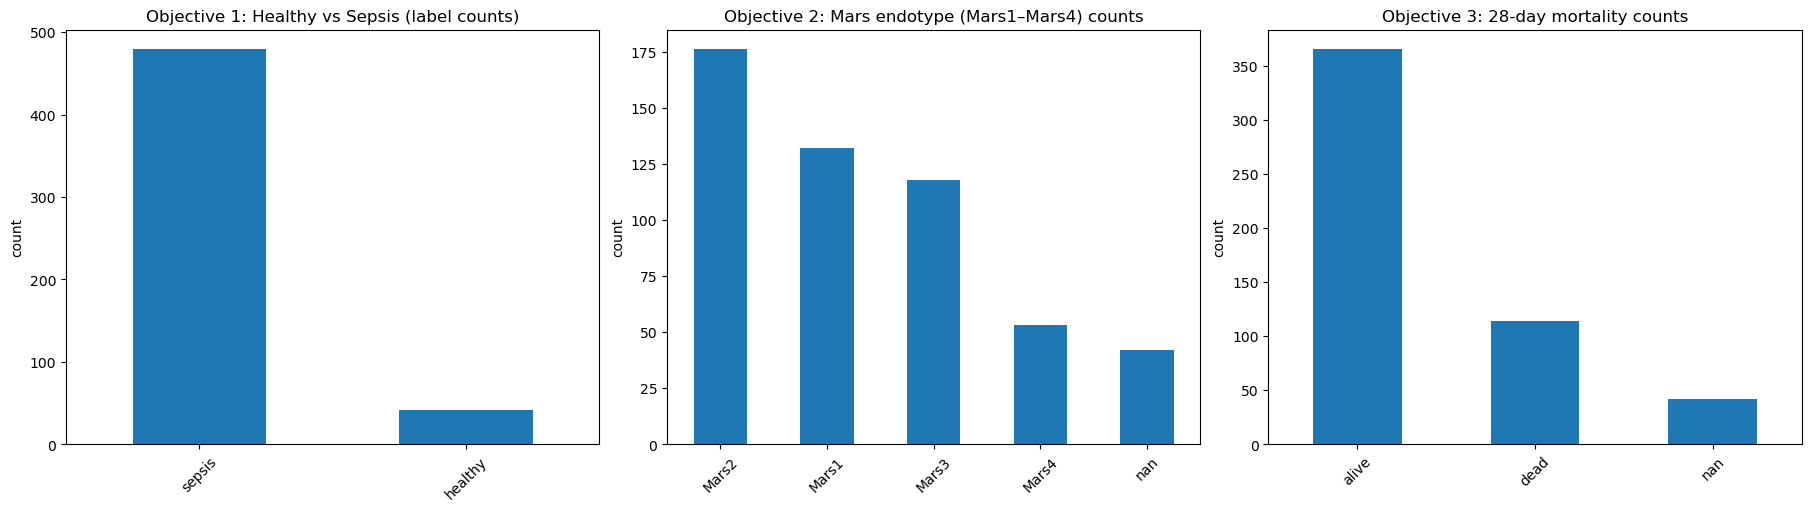

In [ ]:
# Objective 1: Healthy vs Sepsis classification
y1 = pd.Series(index=meta_aligned.index, dtype="float")

if "is_healthy" in meta_aligned.columns:
    meta_aligned["is_healthy"] = meta_aligned["is_healthy"].astype("boolean")
    y1.loc[meta_aligned["is_healthy"] == True] = 0

if "is_mars" in meta_aligned.columns:
    meta_aligned["is_mars"] = meta_aligned["is_mars"].astype("boolean")
    y1.loc[meta_aligned["is_mars"] == True] = 1
print("Objective 1\n", y1.value_counts(dropna=False))
plot_counts(y1.map({0: "healthy", 1: "sepsis"}), "Objective 1: Healthy vs Sepsis (label counts)")

# Objective 2: Mars endotype classification (Mars1–Mars4)
ENDOTYPE_COL = "endotype_class"

if ENDOTYPE_COL in meta_aligned.columns:
    y2 = meta_aligned[ENDOTYPE_COL].astype("object")

    # normalize strings
    y2 = y2.astype(str).replace({"nan": np.nan, "None": np.nan})
    y2 = y2.str.replace("mars", "Mars", case=False)
    y2 = y2.where(y2.isin({"Mars1", "Mars2", "Mars3", "Mars4"}))
    print("Objective 2\n",y2.value_counts(dropna=False))
    plot_counts(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts")
else:
    y2 = pd.Series(index=meta_aligned.index, dtype="object")
    print(f"[WARN] ENDOTYPE_COL '{ENDOTYPE_COL}' not found in metadata.")

# Objective 3: 28-day mortality
MORT_COL = "mortality_event_28days"
TTE_COL  = "time_to_event_28days"

if MORT_COL in meta_aligned.columns:
    y3 = pd.to_numeric(meta_aligned[MORT_COL], errors="coerce")
    print("Objective 3\n",y3.value_counts(dropna=False))
    plot_counts(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts")
else:
    y3 = pd.Series(index=meta_aligned.index, dtype="float")
    print(f"[WARN] MORT_COL '{MORT_COL}' not found in metadata.")

# Combined plot of all three objectives
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
plot_counts_ax(y1.map({0: "healthy", 1: "sepsis"}), "Objective 1: Healthy vs Sepsis (label counts)", ax=axes[0])
plot_counts_ax(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts", ax=axes[1])
plot_counts_ax(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts", ax=axes[2])
plt.show() ############## ORDER PLOTS BY CATEGORIES ##############


There is a general inbalance in the different available labels for the different classes (as mentiones above). While Healthy vs. Sepsis is strongly imbalanced, objective 3 has 365 survivors and 114 diseased patients and NaN patients which represent healthy patients. Objective 2, Mars endotypes are well represented with 176 Mars2, 132 Mars1, 118 Mars3 and 53 Mars4 patients, plus a minority of samples without endotype information (healthy), supporting multi‑class modeling but again with moderate imbalance between endotypes

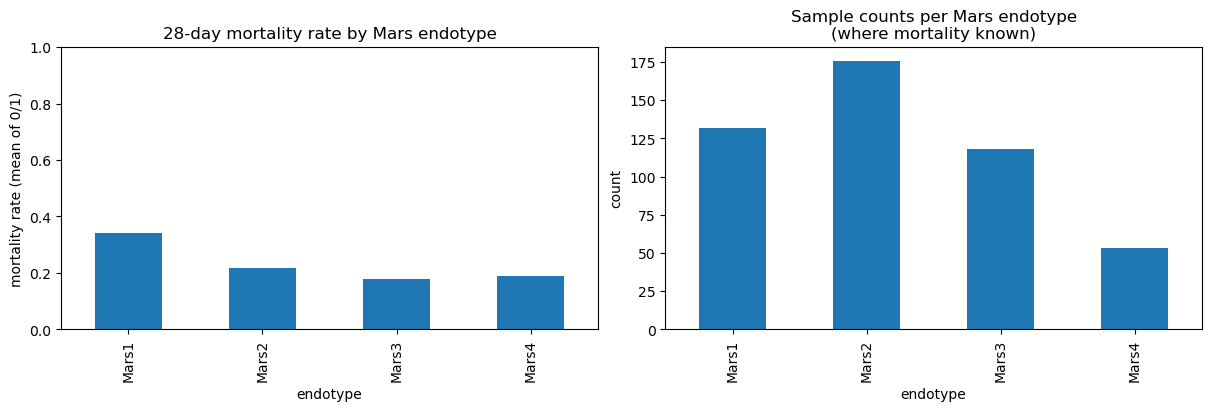

In [10]:
if (ENDOTYPE_COL in meta_aligned.columns) and (MORT_COL in meta_aligned.columns):
    tmp = pd.DataFrame({"endotype": y2, "mortality28": y3}).dropna()

    mort_rate = tmp.groupby("endotype")["mortality28"].mean().sort_index()
    counts = tmp["endotype"].value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Left: mortality rate
    mort_rate.plot(kind="bar", ax=axes[0])
    axes[0].set_title("28-day mortality rate by Mars endotype")
    axes[0].set_ylabel("mortality rate (mean of 0/1)")
    axes[0].set_ylim(0, 1)

    # Right: sample counts
    counts.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Sample counts per Mars endotype\n(where mortality known)")
    axes[1].set_ylabel("count")

    plt.show()

Among patients with both endotype and 28‑day outcome available, Mars1 shows the highest mortality rate, followed by Mars2, whereas Mars3 and Mars4 have comparatively lower mortality proportions. Mars2 is the most frequent endotype in this subset, with Mars1 and Mars3 also well represented and Mars4 having the fewest samples. 
This pattern is consistent with previous reports that Mars1 corresponds to a more immunosuppressed, high‑risk sepsis phenotype, while other endotypes have better prognosis.

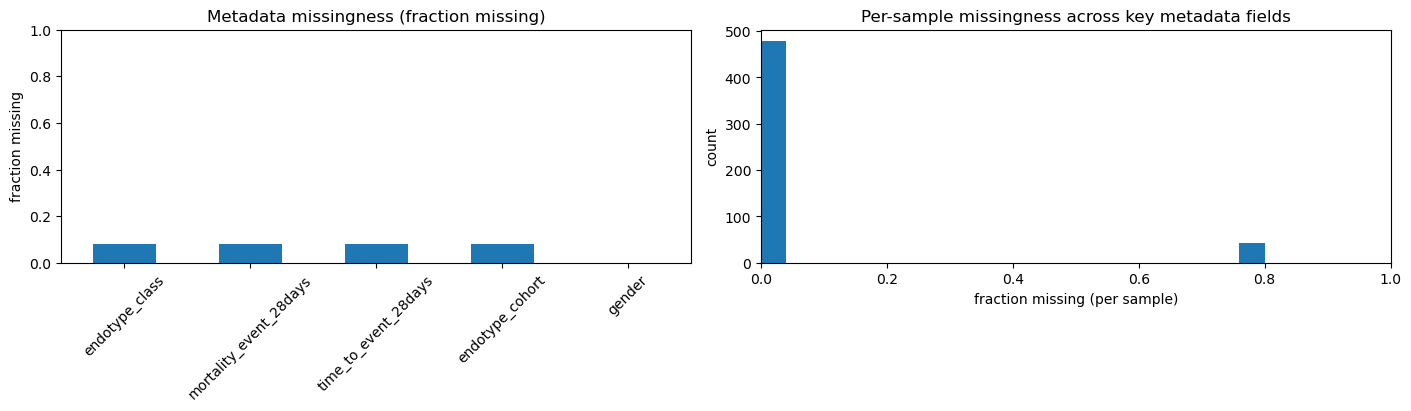

In [38]:
KEY_FIELDS = [
    ENDOTYPE_COL,
    MORT_COL,
    TTE_COL,
    "endotype_cohort",
    "gender",
    # "icu_acquired_infection",
    # "pneumonia_diagnoses"
]
KEY_FIELDS = [c for c in KEY_FIELDS if c in meta_aligned.columns]

if len(KEY_FIELDS) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

    plot_missingness_bar_ax(
        meta_aligned, KEY_FIELDS,
        "Metadata missingness (fraction missing)",
        ax=axes[0]
    )

    miss_sample = plot_missingness_hist_ax(
        meta_aligned, KEY_FIELDS,
        "Per-sample missingness across key metadata fields",
        ax=axes[1]
    )

    plt.show()

    # print("Top 10 samples with most missing key metadata:")
    # print(miss_sample.sort_values(ascending=False).head(10))
else:
    print("[WARN] None of the KEY_FIELDS found in metadata.")

Across key clinical fields, metadata is generally complete with some missing data with a few variables show substantial gaps. Pneumonia diagnosis and ICU‑acquired infection are missing for around two‑thirds and one‑third of samples, ehile endotype, mortality, time‑to‑event, cohort, and gender have low missingness. Per‑sample, most patients have complete or nearly complete metadata, but a small subset of samples lack information for more than 70% of the key fields and are candidates for exclusion or sensitivity analyses in downstream models.

In [12]:
print("Obj1 labeled samples:", y1.notna().sum())
print("Obj2 labeled samples:", y2.notna().sum())
print("Obj3 labeled samples:", y3.notna().sum())

idx1 = y1.dropna().index
idx2 = y2.dropna().index
idx3 = y3.dropna().index

X1, meta1 = X_all.loc[idx1], meta_aligned.loc[idx1]
X2, meta2 = X_all.loc[idx2], meta_aligned.loc[idx2]
X3, meta3 = X_all.loc[idx3], meta_aligned.loc[idx3]

Obj1 labeled samples: 521
Obj2 labeled samples: 479
Obj3 labeled samples: 479


[plot_pca_ax] title=PCA: Healthy vs Sepsis
[plot_pca_ax] X samples=521, genes=11222
[plot_pca_ax] labels non-missing=521 / 521
[plot_pca_ax] samples kept after filtering=521
[plot_pca_ax] index overlap X ∩ labels = 521
[plot_pca_ax] title=PCA: Mars endotypes (Mars1–Mars4)
[plot_pca_ax] X samples=479, genes=11222
[plot_pca_ax] labels non-missing=479 / 479
[plot_pca_ax] samples kept after filtering=479
[plot_pca_ax] index overlap X ∩ labels = 479
[plot_pca_ax] title=PCA: 28-day mortality
[plot_pca_ax] X samples=479, genes=11222
[plot_pca_ax] labels non-missing=479 / 479
[plot_pca_ax] samples kept after filtering=479
[plot_pca_ax] index overlap X ∩ labels = 479


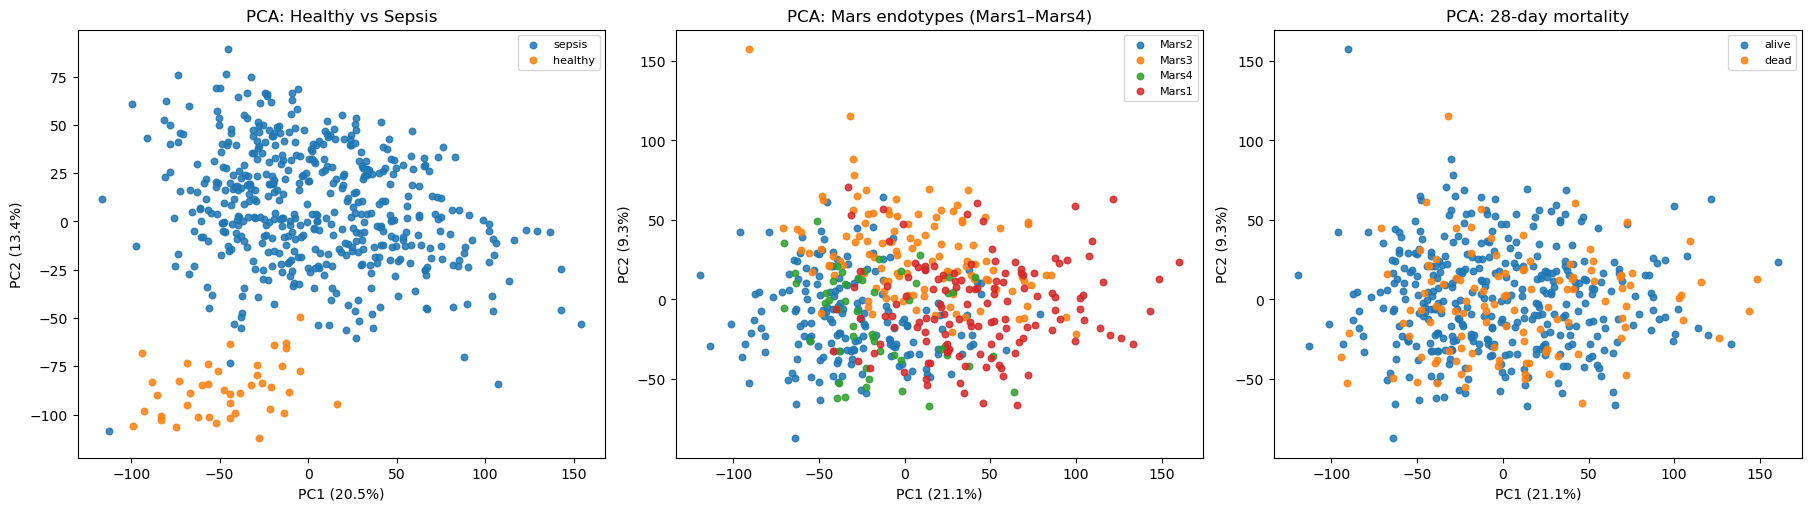

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Objective 1: Healthy vs Sepsis
plot_pca_ax(X1,y1.loc[idx1].map({0: "healthy", 1: "sepsis"}),"PCA: Healthy vs Sepsis",ax=axes[0])

# Objective 2: Mars endotypes
if len(idx2) > 0:
    plot_pca_ax(X2, y2.loc[idx2], "PCA: Mars endotypes (Mars1–Mars4)", ax=axes[1])
else:
    axes[1].axis("off")

# Objective 3: 28-day mortality
if len(idx3) > 0:
    plot_pca_ax(X3, y3.loc[idx3].map({0: "alive", 1: "dead"}), "PCA: 28-day mortality", ax=axes[2])
else:
    axes[2].axis("off")

plt.show()

All samples had a disease-status label (n=521). Endotype and mortality were available for n=479, 521 for healthy vs sepsis, and 479 for both endotype classification and 28‑day mortality prediction. In PCA space, healthy controls separate clearly from septic patients along the first two principal components, indicating strong global transcriptional differences that should support Objective 1. In contrast, Mars endotypes and 28‑day mortality labels do not form sharply separated clusters on the first two PCs, suggesting that endotype and outcome signals are subtler, likely distributed across many genes and requiring supervised models rather than simple linear separation. Coloring by discovery vs validation cohort does not reveal obvious batch‑driven clustering on the top PCs, so large batch corrections may not be necessary beyond standard normalization

#### Feature representation and encoding
Gene expression values are continuous numeric predictors (log2-normalized microarray intensities). No additional feature encoding is required for gene expression.
Outcome labels are encoded as:
- Objective 1: binary (0 = healthy, 1 = sepsis)
- Objective 2: categorical (Mars1–Mars4)
- Objective 3: binary (0 = alive, 1 = dead at/before 28 days)

Transformations that depend on the training data distribution (e.g. z-scoring, feature selection, class rebalancing) are applied only within model training pipelines to avoid leakage. SO LET'S START MODELING!

In [14]:
# Confirm feature types
print("X_all dtype:", X_all.dtypes.unique()[:5])
print("Obj1 label dtype:", y1.dtype)
print("Obj2 label example:", y2.dropna().unique()[:5])
print("Obj3 label dtype:", y3.dtype)

X_all dtype: [dtype('float64')]
Obj1 label dtype: float64
Obj2 label example: ['Mars2' 'Mars3' 'Mars4' 'Mars1']
Obj3 label dtype: float64


### **Modeling**

For each objective, we model baseline blood gene expression as continuous predictors. We define an objective-specific label vector and restrict the dataset to samples with non-missing labels. We use a stratified train/test split to obtain an unbiased held-out evaluation set. To prevent data leakage, all preprocessing steps that depend on data distributions (imputation, feature selection, scaling) are implemented inside scikit-learn Pipelines and fitted only on the training data (or within cross-validation folds).

In [15]:
# -----------------------------
# Freeze label vectors (targets)
# -----------------------------
y_obj1 = y1.copy()  # 0 healthy, 1 sepsis
y_obj2 = y2.copy()  # Mars1-4 strings
y_obj3 = y3.copy()  # 0/1 mortality (NaN for healthy)

# Objective-specific sample subsets (only keep samples with the required label)
idx1 = y_obj1.dropna().index
idx2 = y_obj2.dropna().index
idx3 = y_obj3.dropna().index

X_obj1, y_obj1 = X_all.loc[idx1], y_obj1.loc[idx1]
X_obj2, y_obj2 = X_all.loc[idx2], y_obj2.loc[idx2]
X_obj3, y_obj3 = X_all.loc[idx3], y_obj3.loc[idx3]

print("Obj1:", X_obj1.shape, y_obj1.value_counts())
print("Obj2:", X_obj2.shape, y_obj2.value_counts())
print("Obj3:", X_obj3.shape, y_obj3.value_counts())

Obj1: (521, 11222) 1.0    479
0.0     42
Name: count, dtype: int64
Obj2: (479, 11222) endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
Name: count, dtype: int64
Obj3: (479, 11222) mortality_event_28days
0.0    365
1.0    114
Name: count, dtype: int64


#### **Objective 1: Simple Classifier gfor Healthy vs. Disease**

In [16]:
# cast to integer 0/1 
y_obj1 = y1.copy()
idx = y_obj1.dropna().index
X_obj1 = X_all.loc[idx]
y_obj1 = y_obj1.loc[idx].astype(int)  # ensure 0/1 integers

print("Objective 1 samples:", X_obj1.shape[0])
print(y_obj1.value_counts())

Objective 1 samples: 521
1    479
0     42
Name: count, dtype: int64


In [17]:
# train–test split (80/20)
X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X_obj1, y_obj1,
    test_size=0.2,
    random_state=0,
    stratify=y_obj1
)

The labels were cast to integer 0/1 and a stratified train–test split (80/20) was performed to preserve the strong class imbalance in both sets

Pipeline design:
- The TopVarianceSelector keeps the 5 000 most variable genes, which reduces dimensionality while preserving informative transcriptional variation
- Imputation, variance‑based feature selection, and standardization are all inside a single Pipeline, so they are fitted only on the training data and then applied to the test data, avoiding information leakage
- Logistic regression with class_weight="balanced" is appropriate for the strong class imbalance (≈8:1 sepsis vs healthy) and is a transparent linear baseline model

In [18]:
# Custom transformer for feature selection
# Selects the top N genes with highest variance
# Fit on training data when used inside a Pipeline
class TopVarianceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=5000):
        self.top_n = top_n # Number of genes to keep
        self.features_ = None # Will store indices or names of selected features after fitting

    def fit(self, X, y=None): # Fit the selector by computing feature-wise variance on training data
        if isinstance(X, pd.DataFrame):
            v = X.var(axis=0) # Compute variance for each gene (column)
            self.features_ = v.sort_values(ascending=False).head(self.top_n).index # Select genes with highest variance
        else:
            v = np.var(X, axis=0) # If X is a numpy array, compute variance numerically
            self.features_ = np.argsort(v)[::-1][:self.top_n]
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame): # Reduce X to the selected high-variance features
            return X.loc[:, self.features_]
        return X[:, self.features_]

# Create baseine model using logistic regression
baseline_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")), # Handle any missing expression values

    # Dimensionality reduction:
    ("select", TopVarianceSelector(top_n=5000)), # keep only the top 5000 most variable genes (fit on training data only)

    # Standardize each gene to zero mean and unit variance
    ("scale", StandardScaler()),

    ("clf", LogisticRegression(
        max_iter=5000, # ensure convergence in high-dimensional space
        class_weight="balanced" # handle class imbalance (healthy vs sepsis)
    ))
])


baseline_lr.fit(X1_tr, y1_tr) # Train the pipeline on training data
pred = baseline_lr.predict(X1_te) # Predict class labels on the held-out test set
proba = baseline_lr.predict_proba(X1_te)[:, 1] # Predict class probabilities (used for ROC-AUC)

print("Objective 1 — Baseline Logistic Regression")
print(classification_report(y1_te, pred, target_names=["healthy", "sepsis"]))
print("ROC-AUC:", roc_auc_score(y1_te, proba))
print("Confusion matrix:\n", confusion_matrix(y1_te, pred))

Objective 1 — Baseline Logistic Regression
              precision    recall  f1-score   support

     healthy       0.89      1.00      0.94         8
      sepsis       1.00      0.99      0.99        97

    accuracy                           0.99       105
   macro avg       0.94      0.99      0.97       105
weighted avg       0.99      0.99      0.99       105

ROC-AUC: 1.0
Confusion matrix:
 [[ 8  0]
 [ 1 96]]


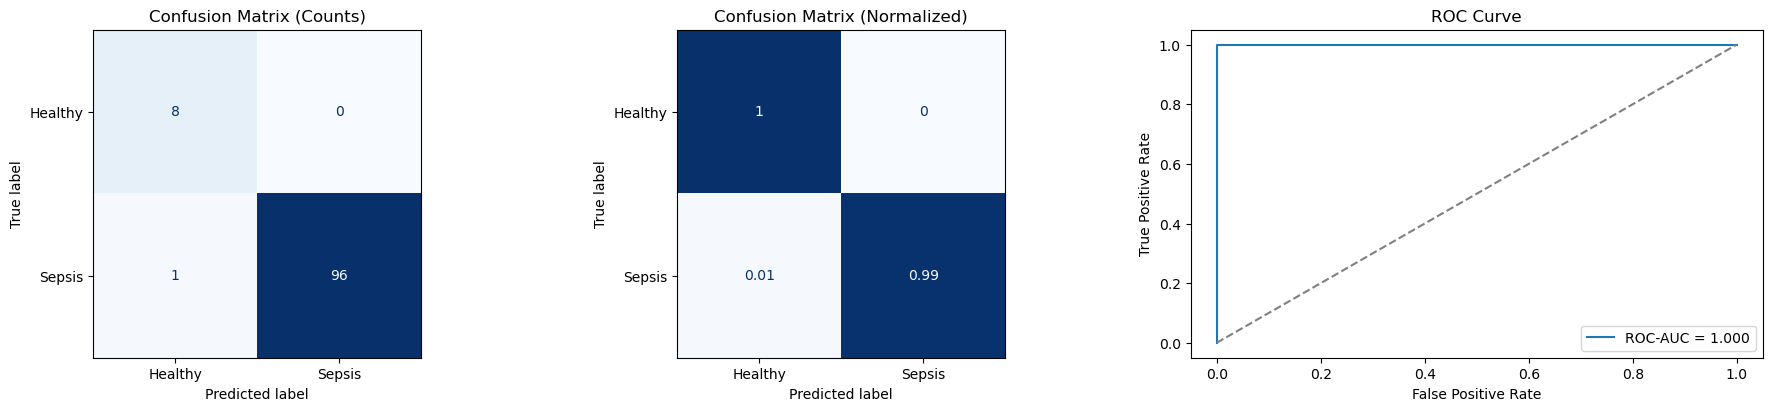

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y1_te, pred)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y1_te, proba)
auc = roc_auc_score(y1_te, proba)

# Create 1x3 layout
fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

# --- Confusion Matrix (counts) ---
disp_counts = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Healthy", "Sepsis"]
)
disp_counts.plot(
    ax=axes[0],
    cmap="Blues",
    colorbar=False
)
axes[0].set_title("Confusion Matrix (Counts)")

# --- Confusion Matrix (normalized by true class) ---
disp_norm = ConfusionMatrixDisplay.from_predictions(
    y1_te,
    pred,
    display_labels=["Healthy", "Sepsis"],
    normalize="true",     # row-normalized → recall per class
    cmap="Blues",
    colorbar=False,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized)")

# --- ROC Curve ---
axes[2].plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC Curve")
axes[2].legend()

plt.show()

##### ***Performance evaluation***
The baseline logistic‑regression pipeline is well designed for this task and performs strongly on the held‑out test set.
The confusion matrix shows 8/8 healthy samples correctly predicted and 96/97 sepsis samples correctly predicted; only one septic patient is misclassified as healthy.
​

For sepsis: precision, recall, and F1 are all ≥ 0.99, while for healthy, recall and F1 are high (1.00 and 0.94), while precision is slightly lower at 0.89, and the ROC–AUC of 1.0 still indicates almost perfect separability between classes.
​

Together with the earlier PCA plots, this suggests that global gene‑expression differences between healthy controls and septic patients are so strong that a simple linear classifier already solves Objective 1 nearly perfectly, leaving limited room for more complex models to improve.
​

It is worth noting that such near‑perfect results on a single random split should still be confirmed with cross‑validation or a strict external validation, but as a baseline this model is both methodologically sound and highly performant. But let's do that !!

To obtain a more robust estimate of model performance, we evaluated the baseline logistic regression model using 5-fold stratified cross-validation. In each fold, the full preprocessing and modeling pipeline was trained on four folds and evaluated on the held-out fold. Performance was again evaluated using ROC-AUC:

In [20]:
# Define a stratified K-fold cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # n_splits=5: split the data into 5 folds, shuffle=True: randomizes sample assignment to folds, random_state ensures reproducibility

# Perform cross-validated evaluation of the baseline logistic regression pipeline
cv_auc = cross_val_score( # full pipeline (imputation, feature selection, scaling, classifier) is re-fitted from scratch on each training fold
    baseline_lr,
    X_obj1,
    y_obj1,
    cv=cv,
    scoring="roc_auc", # used as a threshold-independent performance metric
    n_jobs=-1 # all available CPU cores for parallel computation
)

print("Cross-validated ROC-AUC scores:", cv_auc) # ROC-AUC obtained on each fold
print("Mean ROC-AUC:", cv_auc.mean()) # mean ROC-AUC across folds
print("Std ROC-AUC:", cv_auc.std()) # standard deviation across folds

Cross-validated ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0
Std ROC-AUC: 0.0


Cross‑validation confirms that the baseline logistic‑regression model solves Objective 1 almost perfectly on this dataset. The 5‑fold stratified cross validation results in ROC‑AUC scores of 1.0 in every fold (mean 1.0, standard deviation 0.0), suggesting that the separation between healthy and septic expression profiles is consistently near‑perfect and NOT an artefact of a single train–test split. Together with the confusion matrix and classification report, this supports the conclusion that a simple linear classifier with variance‑based feature selection and class weighting is sufficient for robust healthy‑vs‑sepsis discrimination in this cohort, and that subsequent modelling work will mainly serve as a comparison point rather than a performance improvement for Objective 1.

That is why we continue with further Objectives! Next Objective 2 will be modeling of the Mars endotypes, where it is expected that the results wont be so perfect and performance improvement can be done!

#### <font color='skyblue'>**Objective 2: Mars1–Mars4 endotype classification**</font>


Here we want to compare four models: Logistic Regression, SVM, Random Forest, and Gradient Boosting. Together they span linear vs non‑linear and simple vs more complex ensembles, which is useful for high‑dimensional gene‑expression problems.

Related Sources to this models:
- **Logistic Regression:** https://www.sciencedirect.com/science/article/pii/S235291482100112X
- **Random Forest:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11283789/
- **Gradient Boosting:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10060728/
- **SVM:** https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf

<font color='lightblue'>***Logistic Regression (multinomial)***</font>

Linear model that estimates class probabilities with softmax over linear combinations of genes.
This approach serves as a transparent baseline; if it performs well, it suggests endotypes are largely linearly separable in expression space.
​

<font color='lightblue'>***Support Vector Machine***</font>

Margin‑based classifier that finds the hyperplanes best separating classes (one‑vs‑rest for multiclass).
Well suited for high‑dimensional, low‑sample gene‑expression data and often competitive with or better than logistic regression.
​

<font color='lightblue'>***Random Forest***</font>

Ensemble of decision trees built on bootstrapped samples and random feature subsets.
Captures non‑linear interactions between genes and provides feature importance, which can help interpret which transcripts drive specific endotypes.
​

<font color='lightblue'>***Gradient Boosting (e.g. XGBoost/LightGBM)***</font>

Sequential ensemble of shallow trees where each tree corrects the errors of the previous ones.
Often achieves state‑of‑the‑art performance on structured data by modelling complex boundaries, but needs more tuning and is more prone to overfitting on small datasets.
​

In this dataset, PCA showed that Mars endotypes overlap substantially, unlike the clear healthy–sepsis separation, so it is reasonable to expect: 
- logistic regression and linear SVM to provide strong but limited baselines, and 
- Random Forest and Gradient Boosting to potentially capture additional non‑linear structure and improve accuracy or calibrated probabilities, at the cost of greater model complexity.

In [21]:
# Objective 2 labels
y_obj2 = y2.copy()
idx2 = y_obj2.dropna().index

X_obj2 = X_all.loc[idx2]
y_obj2 = y_obj2.loc[idx2].astype(str)

print("Objective 2 samples:", X_obj2.shape[0])
print(y_obj2.value_counts())

Objective 2 samples: 479
endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
Name: count, dtype: int64


For Objective 2 (Mars1–Mars4), the modelling pipeline treats sepsis endotype prediction as a supervised multi‑class classification problem on high‑dimensional gene‑expression data. Above code restricts dataset to samples with a known endotype label (479 patients), and the class distribution is preserved in a stratified 80/20 train–test split (following code) so that each fold contains representative numbers of Mars1–Mars4 cases.

In [22]:
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X_obj2,
    y_obj2,
    test_size=0.2,
    random_state=0,
    stratify=y_obj2   # preserves Mars1–4 proportions
)

print("Train shape:", X2_tr.shape)
print("Test shape:", X2_te.shape)

Train shape: (383, 11222)
Test shape: (96, 11222)


In [23]:
TOP_N = 5000
CLASSES = ["Mars1", "Mars2", "Mars3", "Mars4"]  # keep a fixed order for plots/metrics

Each model is wrapped in the same preprocessing pipeline. Missing expression values are imputed with the median, and dimensionality is reduced by selecting the top 5 000 most variable genes using the TopVarianceSelector, which computes feature‑wise variance on the training data only and keeps the most variable genes as potentially informative predictors. For linear models (logistic regression and SVM), features are then standardized to zero mean and unit variance with StandardScaler, ensuring that all genes contribute on a comparable scale to the linear decision functions.

In [24]:
models_obj2 = {
    "LogReg (multinomial)": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", TopVarianceSelector(top_n=TOP_N)),
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced"
        ))
    ]),

    "SVM (linear)": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", TopVarianceSelector(top_n=TOP_N)),
        ("scale", StandardScaler()),
        ("clf", SVC(
            kernel="linear",
            class_weight="balanced",
            probability=True,
            random_state=0
        ))
    ]),

    "Random Forest": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", TopVarianceSelector(top_n=TOP_N)),
        ("clf", RandomForestClassifier(
            n_estimators=600,
            random_state=0,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ]),

    "Gradient Boosting": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", TopVarianceSelector(top_n=TOP_N)),
        ("clf", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=0
        ))
    ])
}

Quick comparison of the built models above:

Multinomial Logistic Regression uses a linear softmax model with L2‑regularisation (default) and max_iter=5000 to ensure convergence in the high‑dimensional space. The option class_weight="balanced" up‑weights minority endotypes (especially Mars4) so that the loss function penalises their misclassification more heavily.
​

Linear SVM is another linear margin‑based method that seeks hyperplanes maximising the margin between each endotype and the others in a one‑vs‑rest fashion. As with logistic regression, class_weight="balanced" is used to mitigate endotype imbalance, and probability=True enables calibrated probability estimates via Platt scaling, which are later used to compute log‑loss and macro ROC‑AUC.
​

Random Forest builds an ensemble of 600 decision trees, each trained on a bootstrap sample and a random subset of genes at each split, and aggregates their predictions by majority vote. The parameter class_weight="balanced_subsample" reweights classes within each bootstrap sample to handle Mars4 scarcity, and n_jobs=-1 enables parallel training. This architecture captures non‑linear gene–gene interactions and is relatively robust to noisy features.
​

Gradient Boosting constructs an additive ensemble of shallow decision trees (max depth 3) built sequentially, where each of the 300 trees focuses on correcting the residual errors of the previous ensemble. A relatively small learning rate (0.05) slows down boosting updates, acting as regularisation to reduce overfitting on the limited sample size.

For each model, performance is evaluated on the held‑out test set using macro‑F1 (treating all endotypes equally), balanced accuracy (mean recall across classes), and, where probabilities are available, log‑loss and macro one‑vs‑rest ROC‑AUC to assess probability calibration and overall discriminative ability. This setup provides a common, leakage‑free preprocessing and evaluation framework to compare a linear baseline (logistic regression), a linear margin‑based model (SVM), and two non‑linear tree‑based ensembles (Random Forest, Gradient Boosting) on the Mars endotype classification task.


In [25]:
results = []

for name, model in models_obj2.items():
    model.fit(X2_tr, y2_tr)
    y_pred = model.predict(X2_te)

    row = {
        "model": name,
        "macro_f1": f1_score(y2_te, y_pred, average="macro"),
        "balanced_acc": balanced_accuracy_score(y2_te, y_pred),
    }

    # If model provides probabilities, compute log loss and macro ROC-AUC (OvR)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X2_te)
        row["log_loss"] = log_loss(y2_te, y_proba)
        row["macro_auc_ovr"] = roc_auc_score(y2_te, y_proba, multi_class="ovr", average="macro")
    else:
        row["log_loss"] = None
        row["macro_auc_ovr"] = None

    results.append(row)

results_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
results_df

,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
2,Random Forest,0.863120,0.879568,0.452685,0.977340
3,Gradient Boosting,0.848843,0.856841,0.913460,0.959356
1,SVM (linear),0.814147,0.821722,0.380623,0.974695
0,LogReg (multinomial),0.808810,0.825797,0.802666,0.965212


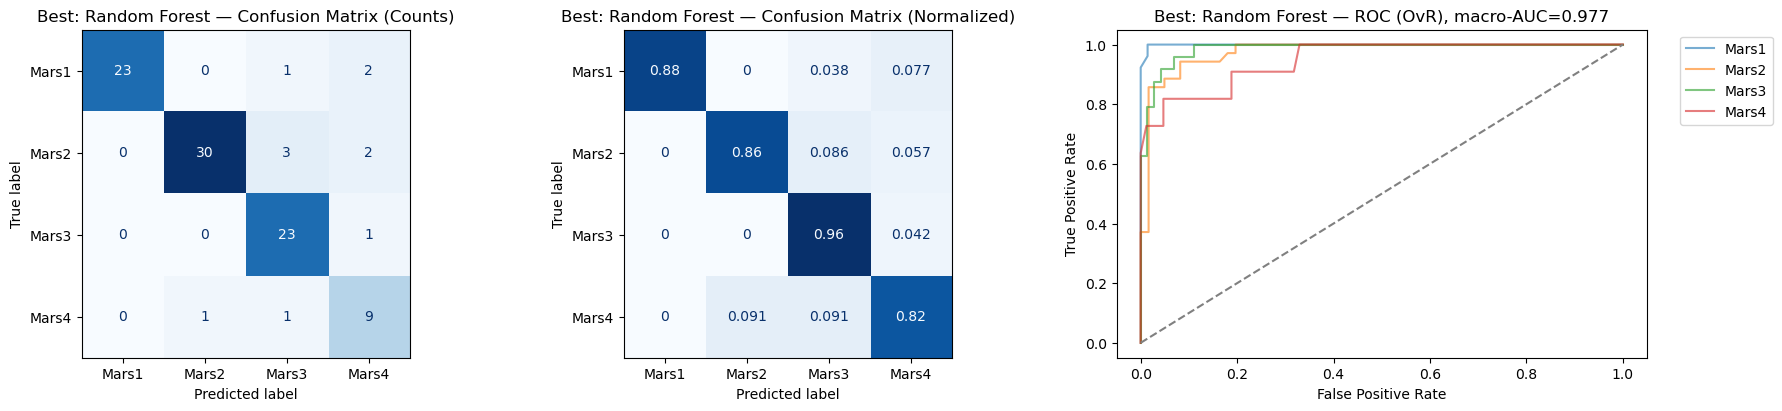

In [26]:
best_name = results_df.iloc[0]["model"]
best_model = models_obj2[best_name]

best_model.fit(X2_tr, y2_tr)
pred_best = best_model.predict(X2_te)

proba_best = best_model.predict_proba(X2_te) if hasattr(best_model, "predict_proba") else None

plot_cm_and_optional_roc(y2_te, pred_best, proba_best, CLASSES, title_prefix=f"Best: {best_name}")

##### ***Performance evaluation***

All four models achieve good multiclass performance, but tree‑based ensembles perform best overall. Random Forest reaches the highest macro‑F1 (≈0.86) and balanced accuracy (≈0.88), and its one‑vs‑rest ROC curves show consistently high class‑specific AUC values (macro‑AUC ≈0.98), with particularly strong discrimination for Mars3 and Mars4 despite their smaller sample sizes. Gradient Boosting is a close second in terms of macro‑F1 and balanced accuracy, but its higher log‑loss indicates less well‑calibrated probabilities than Random Forest or the linear models. The linear SVM and multinomial logistic regression slightly underperform the tree ensembles on F1 yet provide sharper probability estimates, especially the SVM which attains the lowest log‑loss. These results suggest that Mars endotypes are partly linearly separable but also influenced by non‑linear gene interactions that tree‑based models can exploit, making Random Forest a reasonable “best” classifier for downstream analysis. 


In the next step, this model will be tuned in more detail and its feature importances used to derive a ranked list of informative gene symbols, which will serve as a supervised feature‑selection step and as input for subsequent pathway and enrichment analyses to interpret the biological differences between endotypes.

##### <font color='skyblue'>**Hyperparameter Tuning**</font>

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
rf_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("select", TopVarianceSelector()),  # top_n tuned below
    ("clf", RandomForestClassifier(
        random_state=0,
        class_weight="balanced_subsample",
        n_jobs=1  # prevent nested parallelism
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

from scipy.stats import randint

param_dist = {
    "select__top_n": [2000, 5000, 8000],

    "clf__n_estimators": randint(300, 1200),      # more trees = stabler importance
    "clf__max_depth": [None, 10, 20, 30],         # controls complexity / overfitting
    "clf__min_samples_leaf": randint(1, 15),      # helps minority classes (Mars4)
    "clf__max_features": ["sqrt", "log2", 0.2, 0.5]  # feature subsampling strength
}

search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,                 # try 50 later if you want
    scoring="f1_macro",
    cv=cv,
    random_state=0,
    n_jobs=4,                  # 1–2 recommended on laptops
    verbose=2
)

search_rf.fit(X_obj2, y_obj2)

print("Best CV macro-F1:", search_rf.best_score_)
print("Best params:\n", search_rf.best_params_)

best_rf = search_rf.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END clf__max_depth=None, clf__max_features=0.5, clf__min_samples_leaf=6, clf__n_estimators=492, select__top_n=5000; total time= 1.2min
[CV] END clf__max_depth=None, clf__max_features=0.5, clf__min_samples_leaf=6, clf__n_estimators=492, select__top_n=5000; total time= 1.2min
[CV] END clf__max_depth=None, clf__max_features=0.5, clf__min_samples_leaf=6, clf__n_estimators=492, select__top_n=5000; total time= 1.2min
[CV] END clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=3, clf__n_estimators=1104, select__top_n=8000; total time=   1.9s
[CV] END clf__max_depth=None, clf__max_features=0.5, clf__min_samples_leaf=6, clf__n_estimators=492, select__top_n=5000; total time= 1.2min
[CV] END clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=3, clf__n_estimators=1104, select__top_n=8000; total time=   1.9s
[CV] END clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=3, clf__n_estimators=110

In [28]:
best_rf.fit(X2_tr, y2_tr)
pred = best_rf.predict(X2_te)
proba = best_rf.predict_proba(X2_te)

print(classification_report(y2_te, pred))
print("Balanced Acc:", balanced_accuracy_score(y2_te, pred))
print("Macro-F1:", f1_score(y2_te, pred, average="macro"))

              precision    recall  f1-score   support

       Mars1       1.00      0.88      0.94        26
       Mars2       0.97      0.86      0.91        35
       Mars3       0.82      0.96      0.88        24
       Mars4       0.64      0.82      0.72        11

    accuracy                           0.89        96
   macro avg       0.86      0.88      0.86        96
weighted avg       0.90      0.89      0.89        96

Balanced Acc: 0.8795683483183484
Macro-F1: 0.8631204509775938


In [ ]:
# Selected genes after variance selection
selector = best_rf.named_steps["select"]
selected_genes = selector.features_  # gene names

gene_names = X_obj2.columns.to_numpy()          # array of names
selector = best_rf.named_steps["select"]

if isinstance(selector.features_[0], (np.integer, int)):
    selected_gene_names = gene_names[selector.features_]
else:
    selected_gene_names = selector.features_

rf_model = best_rf.named_steps["clf"]
importances = rf_model.feature_importances_

gene_importance_df = (
    pd.DataFrame({"gene": selected_gene_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)
# gene_importance_df.head(20)

,gene,importance
0,TRIM22,0.009880
1,EPB42,0.007596
2,BNIP3L,0.007496
3,IFIT2,0.006174
4,IFIT3,0.005684
5,GLRX5,0.005428
6,UBE2L6,0.005299
7,RNF213,0.005184
8,DACH1,0.005062
9,PARP14,0.004993


In [ ]:
TOP_N_GENES = 100

top_genes = gene_importance_df.head(TOP_N_GENES)["gene"].tolist()
top_genes
# # Plain list file (most tools accept this)
# pd.Series(top_genes).to_csv("rf_mars_top100_genes.txt", index=False, header=False)

# # Also save full table (for appendix)
# gene_importance_df.to_csv("rf_mars_gene_importance.csv", index=False)

# print(f"Saved top {TOP_N_GENES} genes to rf_mars_top100_genes.txt")
# print("Saved full importance table to rf_mars_gene_importance.csv")

['TRIM22',
 'EPB42',
 'BNIP3L',
 'IFIT2',
 'IFIT3',
 'GLRX5',
 'UBE2L6',
 'RNF213',
 'DACH1',
 'PARP14',
 'ISCA1',
 'BPGM',
 'PSMB9',
 'MMADHC',
 'IFIT5',
 'RTP4',
 'GBP1',
 'EPSTI1',
 'ETV7',
 'SERPING1',
 'RIOK3',
 'SAMD9',
 'STAT1',
 'SAMD9L',
 'SERPINB1',
 'CA1',
 'GYG1',
 'LDHA',
 'DCAF12',
 'TAP2',
 'CISD2',
 'PSMB8',
 'STOM',
 'IFI35',
 'SNX3',
 'IFI44',
 'GBP4',
 'ACSL6',
 'IFIT1B',
 'DTX3L',
 'CMPK2',
 'GBP5',
 'IFI44L',
 'NUB1',
 'GBP3',
 'DDX58',
 'ADIPOR1',
 'MIA3',
 'TAP1',
 'NCOA4',
 'UBE2O',
 'FECH',
 'C14orf45',
 'PRDX2',
 'GPR84',
 'FAM46C',
 'C14orf159',
 'IFIH1',
 'CASP1',
 'SESN3',
 'PCMT1',
 'SRBD1',
 'JAZF1',
 'TRANK1',
 'OAS3',
 'FBXO6',
 'SAMSN1',
 'IFITM3',
 'IFI16',
 'OAS1',
 'C5orf56',
 'XAF1',
 'APOL6',
 'TBCEL',
 'RSAD2',
 'STRADB',
 'MPP1',
 'RNF14',
 'CLIC2',
 'MMP8',
 'SLC25A40',
 'MKRN1',
 'PHOSPHO1',
 'NLRC4',
 'GBP7',
 'SDHC',
 'C17orf39',
 'C9orf78',
 'GABARAPL2',
 'PHF11',
 'SPTB',
 'DDX60',
 'BATF2',
 'ATP11B',
 'ACER3',
 'ABCC13',
 'TMEM200B',
 'S

us erandom forest as model for survival -> paper (link)